# 
This notebook serves as an exploratory environment to visualize and analyze the various metrics
computed in `compute_metrics.py`. It provides better insight into the data processing pipeline, allowing
easier debugging, visualization, and fine-tuning of parameters before running the final script.

It includes functions for:
- Loading and cleaning histogram data
- Computing detection efficiency
- Computing single-photon probability
- Computing availability metrics
- Visualizing histograms and final metrics


# Analysis of a single Histogram

## Load the histogram 

In [11]:
import numpy as np
import pandas as pd
import os

# Start from the current working directory
base_dir = os.getcwd()
# Traverse up the directory tree until the expected root folder is found 
while not os.path.exists(os.path.join(base_dir, "MultiHarp150_V3_1")) and base_dir != os.path.dirname(base_dir):
    base_dir = os.path.dirname(base_dir)  # Move up one directory

# Define relative paths and Construct the full path
relative_path = "MultiHarp150_V3_1/HPM_TDC_Deadtime_Characterization/updated_setup_with_refernce_and_wire_delay/Data"
#scan_name = "scan_from_6n_to_1n_10sec_integration/hist_output_delay_4500ps.txt"
scan_name = "coarse_scan_from_500ps_to_1200ps_100ps_step_integration_1hour/hist_output_delay_800ps_integration_3600sec_1.txt"
file_path = os.path.join(base_dir, relative_path, scan_name)

data = pd.read_csv(file_path, sep='\s+', header=None)
non_zero_columns = (data != 0).any()
data = data.loc[:, non_zero_columns]
time_bins = np.arange(len(data))

histograms = {col: data[col].tolist() for col in data.columns}

pump_hist      = np.array(histograms[list(histograms.keys())[0]])
probe_hist    = np.array(histograms[list(histograms.keys())[1]])
detector_hist = np.array(histograms[list(histograms.keys())[2]])

## Get delay (delay_bins) from independent pump and probe histograms 
Because there might be more than 2 peaks due to fluctuations we will apply gaussian fit to get the mean of our distributions

In [12]:
import numpy as np
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, a, mu, sigma):
    """Gaussian function."""
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def fit_gaussian(data, plot=True):

    data = np.array(data)
    x = np.arange(len(data))
    
    a_guess = np.max(data)
    mu_guess = np.sum(x * data) / np.sum(data)  # Weighted mean
    sigma_guess = np.sqrt(np.sum(data * (x - mu_guess) ** 2) / np.sum(data))  # Weighted std dev

    p0 = [a_guess, mu_guess, sigma_guess]

    popt, pcov = curve_fit(gaussian, x, data, p0=p0)
    return popt, pcov

pump_peaks_idx, _ = find_peaks(pump_hist, height=0.07*max(pump_hist))
probe_peaks_idx, _ = find_peaks(probe_hist, height=0.07*max(probe_hist))

pump_params, _ = fit_gaussian(pump_hist[0: (pump_peaks_idx[1]- pump_peaks_idx[0])//2])
probe_params, _ = fit_gaussian(probe_hist[0: (probe_peaks_idx[1]- probe_peaks_idx[0])//2])

delay_bins = probe_params[1] - pump_params[1]
delay_ps   = delay_bins*5
print(delay_ps) # ps

703.8863611381612


## Plot Histogram Data


### Interactive Plots

In [13]:
import numpy as np
import plotly.graph_objects as go

time_ps = time_bins *5

# # Reference Histogram
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x=time_ps, y=pump_hist, mode='lines+markers', name="Reference Histogram"))
# fig1.update_layout(title="Reference - Pump Histogram",
#                    xaxis_title="Time (ps)", yaxis_title="Counts",
#                    template="plotly_white")
# fig1.show()

# #  Delay Histogram
# fig2 = go.Figure()
# fig2.add_trace(go.Scatter(x=time_ps, y=probe_hist, mode='lines+markers', name="Delay Histogram", line=dict(color='red')))
# fig2.update_layout(title="Delay - Probe Histogram",
#                    xaxis_title="Time (ps)", yaxis_title="Counts",
#                    template="plotly_white")
# fig2.show()

# Detector Histogram
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=time_ps, y=detector_hist, mode='lines+markers', name="Detector Histogram", line=dict(color='green')))
fig3.update_yaxes(type="log")
fig3.update_layout(title="Detector Histogram",
                   xaxis_title="Time (ps)", yaxis_title="Counts",
                   template="plotly_white")
fig3.show()

### Static Plots

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Scale time values
time_ps_scaled = time_ps *5

# Create figure and axes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Reference Histogram
axes[0].plot(time_ps_scaled, pump_hist, marker='o', linestyle='-', label="Reference Histogram")
axes[0].set_title("Reference - Pump Histogram")
axes[0].set_ylabel("Counts")
axes[0].legend()
axes[0].set_yscale('log')
axes[0].grid()

# Delay Histogram
axes[1].plot(time_ps_scaled, probe_hist, marker='o', linestyle='-', color='red', label="Delay Histogram")
axes[1].set_title("Delay - Probe Histogram")
axes[1].set_ylabel("Counts")
axes[1].legend()
axes[1].set_yscale('log')
axes[1].grid()

# Detector Histogram
axes[2].plot(time_ps_scaled, detector_hist, marker='o', linestyle='-', color='green', label="Detector Histogram")
axes[2].set_title("Detector Histogram")
axes[2].set_xlabel("Time (ps)")
axes[2].set_ylabel("Counts")
axes[2].set_yscale('log')

axes[2].legend()
axes[2].grid()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Compute availability using only the peak maximum count, not the full histogram integration.

In [14]:
from scipy.signal import find_peaks

peaks_idx, _ = find_peaks(detector_hist, height=0.001*max(detector_hist), distance=delay_bins/2)

if len(peaks_idx) < 4:
    print("second peak finding algorithm. TBD")
 
print(peaks_idx*5)

second peak finding algorithm. TBD
[ 42175 186005 293025]


In [15]:
pump_counts_M  = detector_hist[peaks_idx[0]]   # since the probe will always be the first gaussian 
probe_counts_H = detector_hist[peaks_idx[1]]   # num of detected counts at the second (probe) peak

ref_pump_counts = detector_hist[peaks_idx[2]]
ref_probe_counts = detector_hist[peaks_idx[3]]

norm_pump_counts = pump_counts_M/ref_pump_counts
norm_probe_counts = probe_counts_H/ref_probe_counts

t_delay        = peaks_idx[1] - peaks_idx[0]  # time difference between the two peaks in bins

print(f"Pump availability : {norm_pump_counts:.6f}")
print(f"Probe availability : {norm_probe_counts:.6f}")
print(f"Delay (ps): {t_delay*5:.6f}")

IndexError: index 3 is out of bounds for axis 0 with size 3

## Isolate 1st peak and compute detection_prob_per_pulse

[ 8443  8668 37206 58630]
(array([27.05870061, 49.02295796, 23.94620463, 22.40665247]), array([14031. ,  4094.5, 19228.5, 19622. ]), array([ 8431.59298478,  8646.18797954, 37193.87669574, 58618.00477137]), array([ 8458.65168539,  8695.2109375 , 37217.82290037, 58640.41142384]))


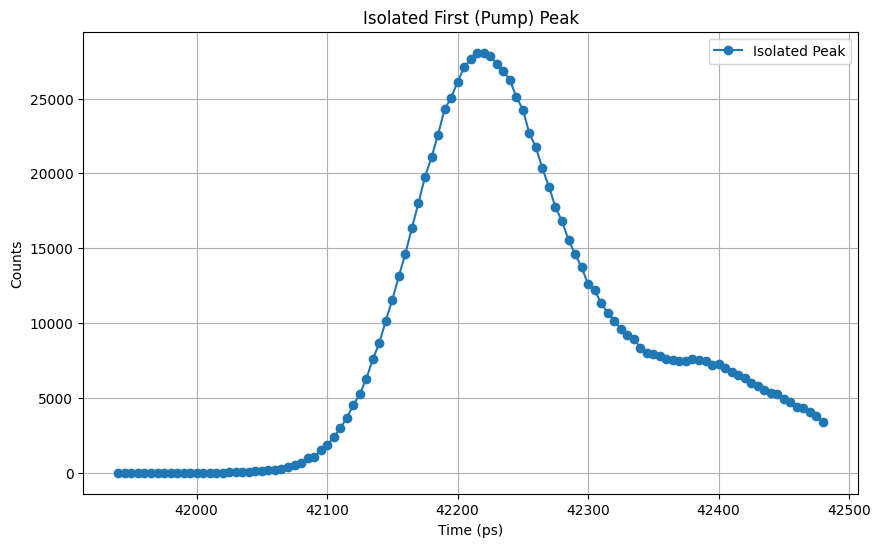

In [56]:
from scipy.signal import peak_widths

# Measure peak width at half maximum
results_half = peak_widths(detector_hist, peaks_idx, rel_height=0.5)
print(peaks_idx)
print(results_half)

# Extract the width of the first peak
peak_width = results_half[0][0]  # Width of first peak

# Define the range for isolation
start_idx = int(peaks_idx[0] - 2* peak_width )
end_idx = int(peaks_idx[0] + 2 * peak_width)
start_idx = max(start_idx, 0)
end_idx = min(end_idx, len(detector_hist) - 1)

plt.figure(figsize=(10, 6))
plt.plot(time_ps[start_idx:end_idx], detector_hist[start_idx:end_idx], label='Isolated Peak', linestyle='-', marker='o')
plt.xlabel("Time (ps)")
plt.ylabel("Counts")
plt.title("Isolated First (Pump) Peak")
plt.legend()
plt.grid()
plt.show()

In [58]:
detection_prob_per_pulse =  sum(detector_hist[start_idx:end_idx])/sum(pump_hist) 
print(f"Probability of detecting at least one photon per laser pulse: {detection_prob_per_pulse}")

Probability of detecting at least one photon per laser pulse: 0.48542168951803627


# Plots of histogram metrics 

## Availability

In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def plot_availability(fig, file_path, label="Dataset"):
    # Read the file
    data = pd.read_csv(
        file_path, 
        sep="\s+", 
        skiprows=1, 
        header=None, 
        names=["pump_ratio", "probe_ratio", "delay_bins", "histogram_name", 
               "pump_height", "probe_height", "ref_pump_height", "ref_probe_height"]
    )

    # Create a dictionary where each key is a column name and the value is the list of column values
    columns_as_lists = {col: data[col].tolist() for col in data.columns}

    # Access individual lists
    pump_ratio_list = columns_as_lists["pump_ratio"]
    probe_ratio_list = columns_as_lists["probe_ratio"]
    delay_bins_list = columns_as_lists["delay_bins"]
    histogram_name_list = columns_as_lists["histogram_name"]
    pump_height_list = columns_as_lists["pump_height"]
    probe_height_list = columns_as_lists["probe_height"]
    ref_pump_height_list = columns_as_lists["ref_pump_height"]
    ref_probe_height_list = columns_as_lists["ref_probe_height"]

    # Convert delay bins to numpy array
    delay_bins_array = np.array(data["delay_bins"])

    # Add a new trace to the same figure
    fig.add_trace(go.Scatter(
        x=delay_bins_array * 5, 
        y=data["pump_ratio"], 
        mode='lines+markers', 
        name=f"{label}",  # Unique label for each dataset
        line=dict(width=2)
    ))

    # Update figure layout only once (outside the function)
    fig.update_yaxes(range=[0, 1])
    fig.update_layout(
        title="Detector Histogram",
        xaxis_title="Time (ps)", 
        yaxis_title="Counts",
        #yaxis_type="log",
        template="plotly_white"
    )

# Create a shared figure object
fig = go.Figure()

# Call the function twice, adding new traces to the same figure
plot_availability(fig, "results/test_coarse_scan.txt", label="Scan 1")
#plot_availability(fig, "analysis/results/coarse_scan_1n_to_6n.txt", label="Scan 2")

# Show the combined plot
fig.show()


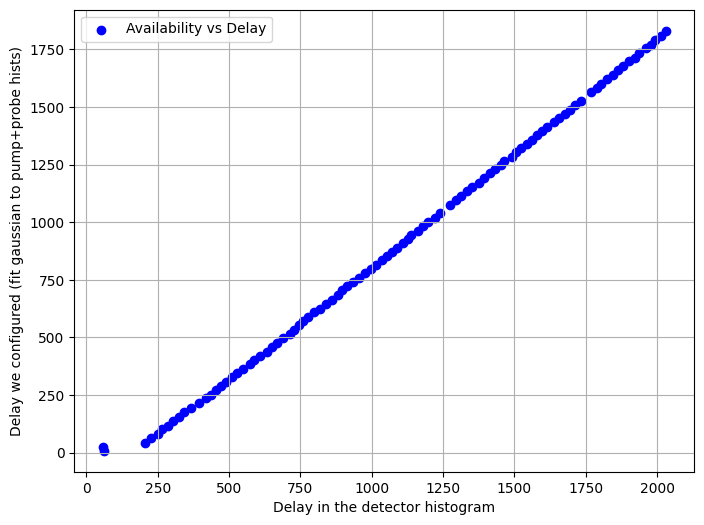

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
file_path = "analysis/results/availability_delay.txt"
data = pd.read_csv(file_path, sep=" ", skiprows=1, header=None, names=["Availability(S)", "Delay(bins)", "Delay(ps)", " Delay_of_ind(bins)" ])

delay_ps = data["Delay(ps)"]
delay_bins = data["Delay(bins)"]
avail_s  =  data["Availability(S)"]
delay_gauss_bins = data[" Delay_of_ind(bins)"]

plt.figure(figsize=(8, 6))
plt.scatter(delay_bins, delay_gauss_bins, marker='o', linestyle='-', color='b', label="Availability vs Delay")

plt.xlabel("Delay in the detector histogram")
plt.ylabel("Delay we configured (fit gaussian to pump+probe hists)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
if any(abs(delay_bins - delay_gauss_bins) > 250): 
    print(delay_bins, delay_gauss_bins)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

spline_s = splrep(delay_ps, avail_s, k=1)

# Generate fine time points
DT_TDC = 650 #ps
t_fine = np.arange(0, delay_ps.max(), DT_TDC)
y_fine = splev(t_fine, spline_s, ext=1)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(delay_ps, avail_s, color='r', label="Original Data", zorder=2) 
plt.plot(t_fine, y_fine, linestyle='-', color='b', label="Linear Spline Fit", zorder=1)  

plt.xlabel("Delay (ps)")
plt.ylabel("Avaiability")
plt.title("Linear Spline Interpolation")
plt.legend()
plt.grid()
plt.show()


NameError: name 'avail_s' is not defined